In [2]:
!pip install unsloth
!pip install triton==3.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of xformers to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 7.0 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.3.0
    Uninstalling triton-3.3.0:
      Successfully uninstalled triton-3.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.7.0 requires triton==3.3.0; platform_system == "Linux" and platform_machine == "x86_64", but you have triton 3.0.0 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.


In [1]:
# ================== IMPORTS ==================

import torch
from unsloth import FastLanguageModel
import matplotlib.pyplot as plt
from datasets import load_dataset
from trl import SFTTrainer
import pandas as pd
import json

from unsloth import FastLanguageModel
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import load_dataset, DatasetDict
import numpy as np
import random


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [8]:
# ================== LOAD MODEL ==================
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "TinyLlama/TinyLlama-1.1B-Chat-v0.4",
    max_seq_length = 512,
    dtype = torch.float16,
    load_in_4bit = True,
)

# ================== APPLY LoRA ==================
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    lora_alpha = 32,
    lora_dropout = 0.05,
    bias = "none"
)

# ================== LOAD + FORMAT DATA ==================
dataset = load_dataset("tatsu-lab/alpaca")

def format_instruction(example):
    return {
        "text": f"### Instruction:\n{example['instruction']}\n\n### Response:\n{example['output']}"
    }

dataset = dataset.map(format_instruction)
dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
dataset

==((====))==  Unsloth 2025.6.8: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.0.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Map:   0%|          | 0/52002 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 46801
    })
    test: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 5201
    })
})

In [9]:
dataset.data

{'train': MemoryMappedTable
 instruction: string
 input: string
 output: string
 text: string
 ----
 instruction: [["Give three tips for staying healthy.","What are the three primary colors?","Describe the structure of an atom.","How can we reduce air pollution?","Describe a time when you had to make a difficult decision.",...,"Name the 6 most populous cities in China.","Edit the following text to make it easier to read","Determine the surface area of the following figure","Find the definition of the following financial term","Describe the flavor profile of the following type of cuisine"],["List 3 historical events related to the following country","Compare and contrast the effects of individual and societal performance","Architact a machine learning algorithm to solve the following problem","Formulate a strategy for a client company that is looking to improve their website's SEO.","Given the dataset, what type of learning algorithm is best suited?",...,"Gather key facts about the hist

In [2]:
# ================== TOKENIZATION ==================
def tokenize(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["instruction", "input", "output", "text"])

# ================== DATA COLLATOR ==================
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# ================== TRAINING CONFIG ==================
training_args = TrainingArguments(
    output_dir="finetuned_tinyllama_alpaca",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=100,
    save_total_limit=2,
    learning_rate=2e-5,
    eval_strategy="epoch",
    fp16=True,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    report_to="none"
)

# ================== TRAINING ==================
FastLanguageModel.for_inference(model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# # ================== SAVE MODEL ==================
# model.save_pretrained("finetuned_tinyllama_alpaca")
# tokenizer.save_pretrained("finetuned_tinyllama_alpaca")


==((====))==  Unsloth 2025.6.8: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.0.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/63.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/513 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.6.8 patched 22 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-a09b74b3ef9c3b(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

Map:   0%|          | 0/52002 [00:00<?, ? examples/s]

Map:   0%|          | 0/46801 [00:00<?, ? examples/s]

Map:   0%|          | 0/5201 [00:00<?, ? examples/s]

/tmp/ipython-input-2-2669950714.py:80: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 46,801 | Num Epochs = 1 | Total steps = 5,851
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 12,615,680/1,100,000,000 (1.15% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Epoch,Training Loss,Validation Loss
1,1.433400,1.362424


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=5851, training_loss=1.3945173709092231, metrics={'train_runtime': 11892.8484, 'train_samples_per_second': 3.935, 'train_steps_per_second': 0.492, 'total_flos': 1.5054928302676378e+17, 'train_loss': 1.3945173709092231, 'epoch': 1.0})

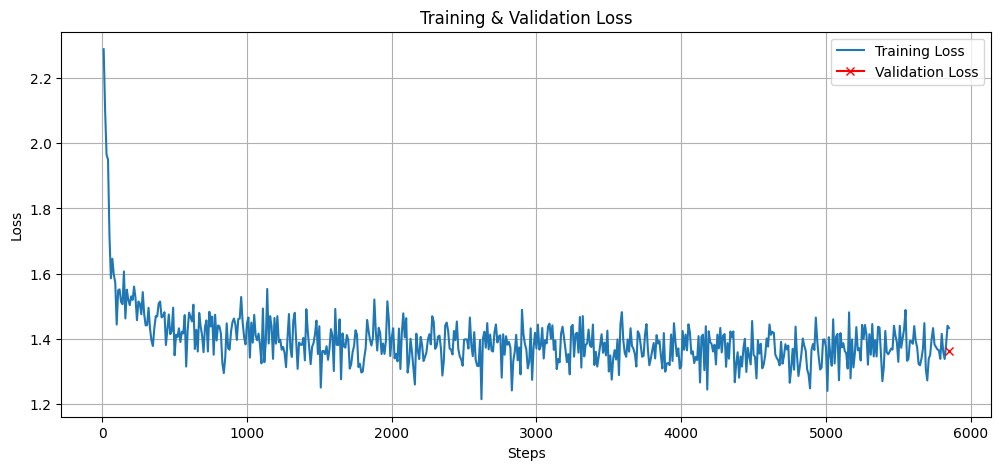

In [7]:
# ================== PLOT ACCURACY AND LOSS ==================
logs = trainer.state.log_history
steps = [log["step"] for log in logs if "loss" in log]
losses = [log["loss"] for log in logs if "loss" in log]
eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(12, 5))
plt.plot(steps, losses, label="Training Loss")
plt.plot(eval_steps, eval_losses, label="Validation Loss",color='red',marker='x')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
eval_losses

[1.3624238967895508]

In [13]:
model.save_pretrained("finetuned_tinyllama_alpaca")
tokenizer.save_pretrained("finetuned_tinyllama_alpaca")

('finetuned_tinyllama_alpaca/tokenizer_config.json',
 'finetuned_tinyllama_alpaca/special_tokens_map.json',
 'finetuned_tinyllama_alpaca/tokenizer.model',
 'finetuned_tinyllama_alpaca/added_tokens.json',
 'finetuned_tinyllama_alpaca/tokenizer.json')